# Notebook exploratoire - Adrian Rodriguez - Projet 3 parcours Ingénieur Machine Learning

---
# 0. Contexte

Vous travaillez pour la **ville de Seattle**. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près aux émissions des bâtiments non destinés à l’habitation.

Des relevés minutieux ont été effectués par vos agents en 2015 et en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, **vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie** de bâtiments pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur les données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction..)

Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe.

Avant de quitter la salle de brief, **Douglas**, le **project lead**, vous donne quelques pistes, et erreurs à éviter :

L’objectif est de te passer des relevés de consommation annuels (attention à la fuite de données), mais rien ne t'interdit d’en déduire des variables plus simples (nature et proportions des sources d’énergie utilisées). 

Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithme de ML à l’aide d’une validation croisée.

J'ai 2 variables à prédire ; la consommation d'énergie d'un site et ses émissions de CO2. Je dois également évaluer l'intérêt de l'Energy Star Score dans la prédiction des émissions carbone.

La consommation d'énergie (kWh ou kBtu) d'un bâtiment est composée de différents facteurs, par ordre d'importance :
- Ses caractéristiques naturelles (placement, orientation, etc),
- Son niveau d'isolation (comble, murs, vitrage, etc),
- Son niveau d'étanchéïté à l'air (VMC, boites électriques, joints, etc... ),
- La performance de ses équipements (production d'eau chaude, équipement de l'utilisateur),
- Son mode de chauffage (électricité, gaz, bois, etc...)

Les émissions de CO2 sont régulées par des facteurs directs et indirects. Par exemple, une énergie électrique produite par fission nucléaire emmettra moins de CO2, qu'une énergie électrique produite au charbon, il s'agit d'un facteur indirect. Si la production d'au chaude est produite directement à l'aide du gaz naturel, il s'agit d'un facteur direct d'émissions de CO2. 

On parle d'émissions en grammes par kWh ou kBtu, les émissions de CO2 sont donc corrélées à la consommation d'énergie.

L'objectif de ce premier travail est de pouvoir extraire les variables qui correspondent le plus aux critères citées précédemment, afin d'obtenir les modèles les plus performants.


---
# 1. Importation et exploration préliminaire

In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
import json

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')

import geopandas as gpd
import folium

## 1-1. Données 2015

In [2]:
# Jeu de données 2015
buildings_2015 = pd.read_csv('src/2015-building-energy-benchmarking.csv')

display(buildings_2015.head())
display(buildings_2015.info())

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,1,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,0.0,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122...",7,DOWNTOWN,1996,1,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,51.0,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,1144563.0,3905411.0,44490.0,4448985.0,0.0,263.51,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122...",7,DOWNTOWN,1969,1,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,NaN,18.0,96.6,99.7,242.7,246.5,73130656.0,75506272.0,19660404.0,14583930.0,49762435.0,37099.0,3709900.0,0.0,2061.48,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,"{'latitude': '47.61421585', 'longitude': '-122...",7,DOWNTOWN,1926,1,10.0,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,1.0,460.4,462.5,636.3,643.2,28229320.0,28363444.0,23458518.0,811521.0,2769023.0,20019.0,2001894.0,0.0,1936.34,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0,18081
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,"{'latitude': '47.6137544', 'longitude': '-122....",7,DOWNTOWN,1980,1,18.0,119890,12460,107430,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,67.0,120.1,122.1,228.8,227.1,14829099.0,15078243.0,0.0,1777841.0,6066245.0,87631.0,8763105.0,0.0,507.70,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,19576


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   OSEBuildingID                                                  3340 non-null   int64  
 1   DataYear                                                       3340 non-null   int64  
 2   BuildingType                                                   3340 non-null   object 
 3   PrimaryPropertyType                                            3340 non-null   object 
 4   PropertyName                                                   3340 non-null   object 
 5   TaxParcelIdentificationNumber                                  3338 non-null   object 
 6   Location                                                       3340 non-null   object 
 7   CouncilDistrictCode                                         

None

In [3]:
# Notice 2015
with open('src/socrata_metadata_2015-building-energy-benchmarking.json') as f:
  info_buildings_2015 = json.load(f)

print(f"{info_buildings_2015['name']}\n")
print(info_buildings_2015['description'])

for i in range(buildings_2015.shape[1]):
    try:
        print(f"{i} {info_buildings_2015['columns'][i]['name']} || {info_buildings_2015['columns'][i]['description']}\n")
    except:
        print(f"{i} {info_buildings_2015['columns'][i]['name']} || No Description\n")

2015 Building Energy Benchmarking

Seattle’s Building Energy Benchmarking and Reporting Program (SMC 22.920) requires owners of non-residential and multifamily buildings (20,000 square feet or larger) to track energy performance and annually report to the City of Seattle. Buildings account for 33% of Seattle's core emissions. The benchmarking policy supports Seattle's goals to reduce energy use and greenhouse gas emissions from existing buildings. In 2013, the City of Seattle adopted a Climate Action Plan to achieve zero net greenhouse gas (GHG) emissions by 2050. Annual benchmarking, reporting and disclosing of building performance are foundational elements of creating more market value for energy efficiency.
Per Ordinance (125000), starting with 2015 energy use performance reporting, the City of Seattle will make the data for all building 20,000 SF and larger available annually. This update to the benchmarking mandate was passed by Seattle City Council on February 29, 2016.

If you h

## 1-2. Données 2016

In [4]:
# Jeu de données 2016
buildings_2016 = pd.read_csv('src/2016-building-energy-benchmarking.csv')

display(buildings_2016.head())
display(buildings_2016.info())

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

None

In [5]:
# Notice 2016
with open('src/socrata_metadata_2016-building-energy-benchmarking.json') as f:
  info_buildings_2016 = json.load(f)

print(f"{info_buildings_2016['name']}\n")
print(info_buildings_2016['description'])

for i in range(buildings_2016.shape[1]):
    try:
        print(f"{i} {info_buildings_2016['columns'][i]['name']} || {info_buildings_2016['columns'][i]['description']}\n")
    except:
        print(f"{i} {info_buildings_2016['columns'][i]['name']} || No Description\n")

2016 Building Energy Benchmarking

Seattle’s Building Energy Benchmarking and Reporting Program (SMC 22.920) requires owners of non-residential and multifamily buildings (20,000 square feet or larger) to track energy performance and annually report to the City of Seattle. Buildings account for 33% of Seattle's core emissions. The benchmarking policy supports Seattle's goals to reduce energy use and greenhouse gas emissions from existing buildings. In 2013, the City of Seattle adopted a Climate Action Plan to achieve zero net greenhouse gas (GHG) emissions by 2050. Annual benchmarking, reporting and disclosing of building performance are foundational elements of creating more market value for energy efficiency.
Per Ordinance (125000), starting with 2015 energy use performance reporting, the City of Seattle will make the data for all building 20,000 SF and larger available annually. This update to the benchmarking mandate was passed by Seattle City Council on February 29, 2016.

If you h

## 1-3. Concaténation des jeux de données 2015 et 2016

Après une brève analyse, le format des dataset ont évolué entre 2015 et 2016. La première étape consiste à restructurer les variables afin d'obtenir un seul et unique jeu de données.

In [6]:
# Transformation des colonnes sous forme de liste
features_2015 = buildings_2015.columns.to_list()
features_2016 = buildings_2016.columns.to_list()

# Features présentes en 2015 et absente en 2016
display([x for x in features_2015 if not x in features_2016])

# Features présentes en 2016 et absente en 2015
display([x for x in features_2016 if not x in features_2015])

['Location',
 'OtherFuelUse(kBtu)',
 'GHGEmissions(MetricTonsCO2e)',
 'GHGEmissionsIntensity(kgCO2e/ft2)',
 'Comment',
 '2010 Census Tracts',
 'Seattle Police Department Micro Community Policing Plan Areas',
 'City Council Districts',
 'SPD Beats',
 'Zip Codes']

['Address',
 'City',
 'State',
 'ZipCode',
 'Latitude',
 'Longitude',
 'Comments',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity']

In [7]:
# Traitement de la colonne location
buildings_2015['Latitude'] = np.nan
buildings_2015['Longitude'] = np.nan
buildings_2015['Address'] = np.nan
buildings_2015['City'] = np.nan
buildings_2015['State'] = np.nan
buildings_2015['ZipCode'] = np.nan

buildings_2015['tmp_location'] = buildings_2015['Location'].str.replace('"',"'").str.split("'")

for i in range(len(buildings_2015)):
    buildings_2015['Latitude'].iloc[i] = buildings_2015['tmp_location'][i][3]
    buildings_2015['Longitude'].iloc[i] = buildings_2015['tmp_location'][i][7]
    buildings_2015['Address'].iloc[i] = buildings_2015['tmp_location'][i][14]
    buildings_2015['City'].iloc[i] = buildings_2015['tmp_location'][i][18]
    buildings_2015['State'].iloc[i] = buildings_2015['tmp_location'][i][22]
    buildings_2015['ZipCode'].iloc[i] = buildings_2015['tmp_location'][i][26]
    
buildings_2015[['Latitude', 'Longitude', 'Address', 'City', 'State', 'ZipCode']]

,Latitude,Longitude,Address,City,State,ZipCode
0,47.61219025,-122.33799744,405 OLIVE WAY,SEATTLE,WA,98101
1,47.61310583,-122.33335756,724 PINE ST,SEATTLE,WA,98101
2,47.61334897,-122.33769944,1900 5TH AVE,SEATTLE,WA,98101
3,47.61421585,-122.33660889,620 STEWART ST,SEATTLE,WA,98101
4,47.6137544,-122.3409238,401 LENORA ST,SEATTLE,WA,98121
...,...,...,...,...,...,...
3335,47.59950256,-122.32034302,321 10TH AVE S,SEATTLE,WA,98104
3336,47.65752471,-122.3160159,4123 12TH AVE NE,SEATTLE,WA,98105
3337,47.61649845,-122.33770787,2030 8TH AVE,SEATTLE,WA,98121
3338,47.68396954,-122.2874088,3801 NE 77TH ST,SEATTLE,WA,98115


In [8]:
# Renommage des colonnes
buildings_2015 = buildings_2015.rename(columns={'Comment': 'Comments'})
buildings_2016 = buildings_2016.rename(columns={'TotalGHGEmissions': 'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity': 'GHGEmissionsIntensity(kgCO2e/ft2)'})

In [9]:
# Attention, pas le même ZipCode dans le fichier 2015. Je garde celui provenant de la variable location, qui est le même format que le fichie de 2016
buildings_2015[['Zip Codes','ZipCode']]

,Zip Codes,ZipCode
0,18081,98101
1,18081,98101
2,18081,98101
3,18081,98101
4,19576,98121
...,...,...
3335,18379,98104
3336,18383,98105
3337,19576,98121
3338,18792,98115


Je vérifie maintenant la cohérence des features entre les jeu de données

In [10]:
# Transformation des colonnes sous forme de liste
features_2015 = buildings_2015.columns.to_list()
features_2016 = buildings_2016.columns.to_list()

# Features présentes en 2015 et absente en 2016
display([x for x in features_2015 if not x in features_2016])

# Features présentes en 2016 et absente en 2015
display([x for x in features_2016 if not x in features_2015])

['Location',
 'OtherFuelUse(kBtu)',
 '2010 Census Tracts',
 'Seattle Police Department Micro Community Policing Plan Areas',
 'City Council Districts',
 'SPD Beats',
 'Zip Codes',
 'tmp_location']

[]

Toutes les variables du fichier 2016 sont répliquées dans le fichier 2015. 

Toutes les variables du fichier 2015 non répliquées dans 2016 peuvent être supprimmées pour la concaténation.

In [11]:
# Suppression des variables inutiles avant concaténation
buildings_2015 = buildings_2015.drop(columns=[x for x in features_2015 if not x in features_2016])

In [12]:
# Concaténation des datasets
buildings = buildings_2015.append(buildings_2016).reset_index(drop=True)
buildings

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comments,ComplianceStatus,Outlier,Latitude,Longitude,Address,City,State,ZipCode
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,7,DOWNTOWN,1927,1.0,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.900000,80.300000,173.500000,175.100000,6.981428e+06,7.097539e+06,2023032.0,1.080307e+06,3.686160e+06,12724.000000,1.272388e+06,249.43,2.64,No,NaN,Compliant,NaN,47.61219025,-122.33799744,405 OLIVE WAY,SEATTLE,WA,98101
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,7,DOWNTOWN,1996,1.0,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,51.0,94.400000,99.000000,191.300000,195.200000,8.354235e+06,8.765788e+06,0.0,1.144563e+06,3.905411e+06,44490.000000,4.448985e+06,263.51,2.38,No,NaN,Compliant,NaN,47.61310583,-122.33335756,724 PINE ST,SEATTLE,WA,98101
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,7,DOWNTOWN,1969,1.0,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,NaN,18.0,96.600000,99.700000,242.700000,246.500000,7.313066e+07,7.550627e+07,19660404.0,1.458393e+07,4.976244e+07,37099.000000,3.709900e+06,2061.48,1.92,Yes,NaN,Compliant,NaN,47.61334897,-122.33769944,1900 5TH AVE,SEATTLE,WA,98101
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,7,DOWNTOWN,1926,1.0,10.0,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,1.0,460.400000,462.500000,636.300000,643.200000,2.822932e+07,2.836344e+07,23458518.0,8.115210e+05,2.769023e+06,20019.000000,2.001894e+06,1936.34,31.38,No,NaN,Compliant,High Outlier,47.61421585,-122.33660889,620 STEWART ST,SEATTLE,WA,98101
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,7,DOWNTOWN,1980,1.0,18.0,119890,12460,107430,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,67.0,120.100000,122.100000,228.800000,227.100000,1.482910e+07,1.507824e+07,0.0,1.777841e+06,6.066245e+06,87631.000000,8.763105e+06,507.70,4.02,No,NaN,Compliant,NaN,47.6137544,-122.3409238,401 LENORA ST,SEATTLE,WA,98121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6711,50222,2016,Nonresidential COS,Office,Horticulture building,1624049080,2,GREATER DUWAMISH,1990,1.0,1.0,12294,0,12294,Office,Office,12294.0,NaN,NaN,NaN,NaN,NaN,46.0,69.099998,76.699997,161.699997,176.100006,8.497457e+05,9.430032e+05,0.0,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,20.94,1.70,True,NaN,Error - Correct Default Data,NaN,47.5672,-122.312,1600 S Dakota St,Seattle,WA,NaN
6712,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,3558300000,2,DOWNTOWN,2004,1.0,1.0,16000,0,16000,Other - Recreation,Other - Recreation,16000.0,NaN,NaN,NaN,NaN,NaN,NaN,59.400002,65.900002,114.199997,118.900001,9.502762e+05,1.053706e+06,0.0,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,32.17,2.01,False,NaN,Compliant,NaN,47.5962,-122.323,719 8th Ave S,Seattle,WA,NaN
6713,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1794501150,7,MAGNOLIA / QUEEN ANNE,1974,1.0,1.0,13157,0,13157,"Fitness Center/Health Club/Gym, Other - Recrea...",Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimm

In [13]:
# Les dataset ont le même nombre de colonne. La concaténation s'est déroulée correctement.
display(buildings_2015.shape)
display(buildings_2016.shape)
display(buildings.shape)

(3340, 46)

(3376, 46)

(6716, 46)

In [14]:
buildings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6716 entries, 0 to 6715
Data columns (total 46 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   OSEBuildingID                      6716 non-null   int64  
 1   DataYear                           6716 non-null   int64  
 2   BuildingType                       6716 non-null   object 
 3   PrimaryPropertyType                6716 non-null   object 
 4   PropertyName                       6716 non-null   object 
 5   TaxParcelIdentificationNumber      6714 non-null   object 
 6   CouncilDistrictCode                6716 non-null   int64  
 7   Neighborhood                       6716 non-null   object 
 8   YearBuilt                          6716 non-null   int64  
 9   NumberofBuildings                  6708 non-null   float64
 10  NumberofFloors                     6708 non-null   float64
 11  PropertyGFATotal                   6716 non-null   int64

---
# 3. Nettoyage du jeu de données
## 3-1. Traitement des bâtiments en double

In [15]:
duplicates = buildings.duplicated(subset='OSEBuildingID', keep=False)
buildings[duplicates].sort_values(by='OSEBuildingID')

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comments,ComplianceStatus,Outlier,Latitude,Longitude,Address,City,State,ZipCode
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,7,DOWNTOWN,1927,1.0,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.900000,80.300000,173.500000,175.100000,6.981428e+06,7.097539e+06,2023032.0,1.080307e+06,3686160.0,12724.00000,1272388.0,249.43,2.64,No,NaN,Compliant,NaN,47.61219025,-122.33799744,405 OLIVE WAY,SEATTLE,WA,98101
3340,1,2016,NonResidential,Hotel,Mayflower park hotel,0659000030,7,DOWNTOWN,1927,1.0,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7.226362e+06,7.456910e+06,2003882.0,1.156514e+06,3946027.0,12764.52930,1276453.0,249.98,2.83,False,NaN,Compliant,NaN,47.6122,-122.338,405 Olive way,Seattle,WA,98101
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,7,DOWNTOWN,1996,1.0,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,51.0,94.400000,99.000000,191.300000,195.200000,8.354235e+06,8.765788e+06,0.0,1.144563e+06,3905411.0,44490.00000,4448985.0,263.51,2.38,No,NaN,Compliant,NaN,47.61310583,-122.33335756,724 PINE ST,SEATTLE,WA,98101
3341,2,2016,NonResidential,Hotel,Paramount Hotel,0659000220,7,DOWNTOWN,1996,1.0,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8.387933e+06,8.664479e+06,0.0,9.504252e+05,3242851.0,51450.81641,5145082.0,295.86,2.86,False,NaN,Compliant,NaN,47.6132,-122.334,724 Pine street,Seattle,WA,98101
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,7,DOWNTOWN,1969,1.0,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,NaN,18.0,96.600000,99.700000,242.700000,246.500000,7.313066e+07,7.550627e+07,19660404.0,1.458393e+07,49762435.0,37099.00000,3709900.0,2061.48,1.92,Yes,NaN,Compliant,NaN,47.61334897,-122.33769944,1900 5TH AVE,SEATTLE,WA,98101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3337,50057,2015,Multifamily HR (10+),High-Rise Multifamily,CIRRUS,660000575,7,DOWNTOWN,2015,1.0,40.0,319481,41915,277566,"Multifamily Housing, Parking",NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.0,52.700000,61.400000,93.100000,102.200000,1.683441e+07,1.962336e+07,0.0,1.690364e+06,5767761.0,110669.00000,11066893.0,627.97,1.89,No,NaN,Compliant,NaN,47.61649845,-122.33770787,2030 8TH AVE,SEATTLE,WA,98121
6674,50058,2016,Multifamily LR (1-4),Low-Rise Multifamily,Wedgewood Estates Building A,6392001040,4,NORTHEAST,1981,1.0,3.0,48230,0,48230,"Multifamily Housing, Parking",Multifamily Housing,26175.0,Parking,16425.0,NaN,NaN,NaN,80.0,29.900000,31.600000,94.000000,99.400002,7.833457e+05,8.283887e+05,0.0,2.295855e+05,783346.0,0.00000,0.0,5.46,0.11,False,NaN,Compliant,NaN,47.6844,-122.287,3801 NE 77th St,Seattle,WA,98115
3338,50058,2015,Multifamily LR (1-4),Low-Rise Multifamily,WEDGEWOOD ESTATES BLDG A,6392001040,4,NORTHEAST,1981,1.0,3.0,48230,0,48230,Multifamily Housing,Multifamily Housing,22310.0,NaN,NaN,NaN,NaN,NaN,44.0,34.800000,38.100000,109.400000,119.500000,7.770640e+05,8.492500e+05,

Il y a des bâtiments présents en 2015 et en 2016. Si je l'ai laisse cela faussera ma modélisation car le bâtiment n'existe pas 2 fois physiquement. De ce fait, je décide de garder l'observation la plus récente en cas de doublon, soit 2016.

In [16]:
buildings = buildings.sort_values(by=['OSEBuildingID', 'DataYear']).drop_duplicates('OSEBuildingID', keep='last')
buildings

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comments,ComplianceStatus,Outlier,Latitude,Longitude,Address,City,State,ZipCode
3340,1,2016,NonResidential,Hotel,Mayflower park hotel,0659000030,7,DOWNTOWN,1927,1.0,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7.226362e+06,7.456910e+06,2003882.00,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,249.98,2.83,False,NaN,Compliant,NaN,47.6122,-122.338,405 Olive way,Seattle,WA,98101
3341,2,2016,NonResidential,Hotel,Paramount Hotel,0659000220,7,DOWNTOWN,1996,1.0,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8.387933e+06,8.664479e+06,0.00,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,295.86,2.86,False,NaN,Compliant,NaN,47.6132,-122.334,724 Pine street,Seattle,WA,98101
3342,3,2016,NonResidential,Hotel,5673-The Westin Seattle,0659000475,7,DOWNTOWN,1969,1.0,41.0,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,7.258702e+07,7.393711e+07,21566554.00,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,2089.28,2.19,False,NaN,Compliant,NaN,47.6139,-122.338,1900 5th Avenue,Seattle,WA,98101
3343,5,2016,NonResidential,Hotel,HOTEL MAX,0659000640,7,DOWNTOWN,1926,1.0,10.0,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6.794584e+06,6.946800e+06,2214446.25,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,286.43,4.67,False,NaN,Compliant,NaN,47.6141,-122.337,620 STEWART ST,Seattle,WA,98101
3344,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),0659000970,7,DOWNTOWN,1980,1.0,18.0,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,1.417261e+07,1.465650e+07,0.00,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,505.01,2.88,False,NaN,Compliant,NaN,47.6138,-122.34,401 LENORA ST,Seattle,WA,98121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6711,50222,2016,Nonresidential COS,Office,Horticulture building,1624049080,2,GREATER DUWAMISH,1990,1.0,1.0,12294,0,12294,Office,Office,12294.0,NaN,NaN,NaN,NaN,NaN,46.0,69.099998,76.699997,161.699997,176.100006,8.497457e+05,9.430032e+05,0.00,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,20.94,1.70,True,NaN,Error - Correct Default Data,NaN,47.5672,-122.312,1600 S Dakota St,Seattle,WA,NaN
6712,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,3558300000,2,DOWNTOWN,2004,1.0,1.0,16000,0,16000,Other - Recreation,Other - Recreation,16000.0,NaN,NaN,NaN,NaN,NaN,NaN,59.400002,65.900002,114.199997,118.900001,9.502762e+05,1.053706e+06,0.00,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,32.17,2.01,False,NaN,Compliant,NaN,47.5962,-122.323,719 8th Ave S,Seattle,WA,NaN
6713,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1794501150,7,MAGNOLIA / QUEEN ANNE,1974,1.0,1.0,13157,0,13157,"Fitness Center/Health Club/Gym, Other - Recrea...",Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimming Pool,0.0,NaN,NaN,438.20001

## 3-2. Exclusion des bâtiments résidentiels

In [17]:
buildings.BuildingType.value_counts()

NonResidential          1488
Multifamily LR (1-4)    1040
Multifamily MR (5-9)     584
Multifamily HR (10+)     110
SPS-District K-12         99
Nonresidential COS        85
Campus                    25
Nonresidential WA          1
Name: BuildingType, dtype: int64

Pour dissocier les bâtiments résidentiels des non-résidentiels, j'utilise la variable PrimaryPropertyType qui sait dissocier la nature des bâtiments dans le campus (entre salle de cours et résidences étudiantes) 

In [18]:
buildings = buildings[buildings.PrimaryPropertyType.str.find('Multifamily') == -1]
buildings = buildings[buildings.PrimaryPropertyType.str.find('Residence') == -1]
buildings

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comments,ComplianceStatus,Outlier,Latitude,Longitude,Address,City,State,ZipCode
3340,1,2016,NonResidential,Hotel,Mayflower park hotel,0659000030,7,DOWNTOWN,1927,1.0,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7.226362e+06,7.456910e+06,2003882.00,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,249.98,2.83,False,NaN,Compliant,NaN,47.6122,-122.338,405 Olive way,Seattle,WA,98101
3341,2,2016,NonResidential,Hotel,Paramount Hotel,0659000220,7,DOWNTOWN,1996,1.0,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8.387933e+06,8.664479e+06,0.00,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,295.86,2.86,False,NaN,Compliant,NaN,47.6132,-122.334,724 Pine street,Seattle,WA,98101
3342,3,2016,NonResidential,Hotel,5673-The Westin Seattle,0659000475,7,DOWNTOWN,1969,1.0,41.0,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,7.258702e+07,7.393711e+07,21566554.00,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,2089.28,2.19,False,NaN,Compliant,NaN,47.6139,-122.338,1900 5th Avenue,Seattle,WA,98101
3343,5,2016,NonResidential,Hotel,HOTEL MAX,0659000640,7,DOWNTOWN,1926,1.0,10.0,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6.794584e+06,6.946800e+06,2214446.25,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,286.43,4.67,False,NaN,Compliant,NaN,47.6141,-122.337,620 STEWART ST,Seattle,WA,98101
3344,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),0659000970,7,DOWNTOWN,1980,1.0,18.0,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,1.417261e+07,1.465650e+07,0.00,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,505.01,2.88,False,NaN,Compliant,NaN,47.6138,-122.34,401 LENORA ST,Seattle,WA,98121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6711,50222,2016,Nonresidential COS,Office,Horticulture building,1624049080,2,GREATER DUWAMISH,1990,1.0,1.0,12294,0,12294,Office,Office,12294.0,NaN,NaN,NaN,NaN,NaN,46.0,69.099998,76.699997,161.699997,176.100006,8.497457e+05,9.430032e+05,0.00,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,20.94,1.70,True,NaN,Error - Correct Default Data,NaN,47.5672,-122.312,1600 S Dakota St,Seattle,WA,NaN
6712,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,3558300000,2,DOWNTOWN,2004,1.0,1.0,16000,0,16000,Other - Recreation,Other - Recreation,16000.0,NaN,NaN,NaN,NaN,NaN,NaN,59.400002,65.900002,114.199997,118.900001,9.502762e+05,1.053706e+06,0.00,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,32.17,2.01,False,NaN,Compliant,NaN,47.5962,-122.323,719 8th Ave S,Seattle,WA,NaN
6713,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1794501150,7,MAGNOLIA / QUEEN ANNE,1974,1.0,1.0,13157,0,13157,"Fitness Center/Health Club/Gym, Other - Recrea...",Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimming Pool,0.0,NaN,NaN,438.20001

## 3-3. Vérification de la consistance des données 
### 3-3-1. Surface au sol (GFA)

Je vérifie la consistance des données liée aux surfaces au sol (GFA : gross floor area). D'après la notice, je sais que la surface totale GFA de la propriété doit être égale à la somme des surfaces GFA des bâtiments et des parkings (`PropertyGFATotal` = `PropertyGFAParking` + `PropertyGFABuilding(s)`)

In [19]:
# GFA : gross floor area (Surface au sol)
sum_propertyGFA = buildings[['PropertyGFAParking','PropertyGFABuilding(s)']].sum(axis=1)
buildings_equ = sum_propertyGFA == buildings.PropertyGFATotal

consistent_buildings = buildings[buildings_equ]

display(consistent_buildings.shape)
buildings = consistent_buildings

(1727, 46)

Toutes mes données sont GFA sont consistantes

### 3-3-2. Site Energy Use
D'après le convertisseur google, je sais que 1kWh = 3412.14 kBtu. Je n'irai pas jusqu'à vérifier les conversions puisque la majorité des données sont en kBtu. Unité que je conserve pour la suite du projet.

In [20]:
buildings[['SiteEnergyUse(kBtu)','SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']].describe()

,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu)
count,1.724000e+03,1.724000e+03,1.724000e+03,1.724000e+03
mean,8.467167e+06,5.253137e+05,5.825505e+06,2.008183e+06
std,3.001809e+07,5.471607e+06,2.054837e+07,9.420325e+06
min,0.000000e+00,0.000000e+00,-1.154170e+05,0.000000e+00
25%,1.223105e+06,0.000000e+00,7.250722e+05,0.000000e+00
50%,2.563995e+06,0.000000e+00,1.632788e+06,5.044845e+05
75%,6.863508e+06,0.000000e+00,4.788530e+06,1.536392e+06
max,8.739237e+08,1.349435e+08,6.570744e+08,2.979090e+08


In [21]:
buildings[buildings['Electricity(kBtu)'] < 0]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comments,ComplianceStatus,Outlier,Latitude,Longitude,Address,City,State,ZipCode
6546,49784,2016,NonResidential,Small- and Mid-Sized Office,Bullitt Center,7234600195,3,CENTRAL,2013,1.0,6.0,52000,0,52000,Office,Office,48159.0,NaN,NaN,NaN,NaN,NaN,100.0,7.1,5.0,2.0,-2.1,342726.0938,240132.0938,0.0,-33826.80078,-115417.0,0.0,0.0,-0.8,-0.02,False,NaN,Compliant,NaN,47.6143,-122.313,1501 E. Madison St.,Seattle,WA,98122


Je constate que j'ai un bâtiment qui consomme de l'énergie tout en ayant une variable `Electricity(kBtu)` négative. Le status 'compliant' (conforme) de la part de la ville m'indique que qu'il ne s'agit pas d'une erreur. J'en déduis que ce bâtiment produit de l'électricité. Toutefois, il ne doit pas entrer en compte dans la modélisation.

Je vérifie l'information suivante :
- Le total de la consommation en énergie doit être égale à la somme des types d'énergie consomées (`SiteEnergyUse(kBtu)` = `SteamUse(kBtu)` + `Electricity(kBtu)` + `NaturalGas(kBtu)` + `OtherFuelUse(kBtu)`)

In [22]:
sum_EU = buildings[['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']].sum(axis=1)
tolerance = [0.99,0.5,0.2,0.1,0,0.05]

for tol in tolerance:
    low_level = 1 - tol
    high_level = 1 + tol

    buildings_EU = (buildings['SiteEnergyUse(kBtu)'] >= sum_EU * low_level) & (buildings['SiteEnergyUse(kBtu)'] <= sum_EU * high_level)

    consistent_buildings = buildings[buildings_EU]
    display(consistent_buildings.shape)

(1708, 46)

(1706, 46)

(1702, 46)

(1695, 46)

(272, 46)

(1693, 46)

Avec un tolérance à 5%, je conserve la quasi-totalité de mes observations. Je conserve ce paramètre. Je note qu'avec une tolérance à 0% je perds quasiment tout le jeu de données. Cela est du aux arrondis.

In [23]:
buildings = consistent_buildings

### 3-3-3. Consommation énergie nulle

In [24]:
buildings[['SiteEnergyUse(kBtu)','GHGEmissions(MetricTonsCO2e)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)']].sort_values(by='SiteEnergyUse(kBtu)').head(10)

,SiteEnergyUse(kBtu),GHGEmissions(MetricTonsCO2e),Electricity(kBtu),NaturalGas(kBtu),SteamUse(kBtu)
4100,0.00000,0.00,0.0,0.0,0.0
3644,0.00000,0.00,0.0,0.0,0.0
3368,0.00000,0.00,0.0,0.0,0.0
4086,0.00000,0.00,0.0,0.0,0.0
3492,0.00000,0.00,0.0,0.0,0.0
4701,0.00000,0.00,0.0,0.0,0.0
5529,16808.90039,0.12,16809.0,0.0,0.0
4569,24105.50000,0.17,24105.0,0.0,0.0
4635,44293.50000,0.31,44294.0,0.0,0.0
4917,57133.19922,0.40,57133.0,0.0,0.0


In [25]:
buildings = buildings[buildings['SiteEnergyUse(kBtu)'] > 0]

### 3-3-4. Hauteur des tours

In [26]:
buildings.sort_values(by='NumberofFloors', ascending=False).head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comments,ComplianceStatus,Outlier,Latitude,Longitude,Address,City,State,ZipCode
4699,21611,2016,NonResidential,Worship Facility,Seattle Chinese Baptist Church,2124049098,2,GREATER DUWAMISH,1977,1.0,99.0,21948,0,21948,Worship Facility,Worship Facility,21948.0,NaN,NaN,NaN,NaN,NaN,80.0,14.900000,14.900000,46.599998,46.599998,3.260012e+05,3.260012e+05,0.000,95545.5,326001.0,0.00000,0.0,2.27,0.10,False,NaN,Compliant,NaN,47.5507,-122.303,5801 Beacon Avenue South,Seattle,WA,98108
3899,775,2016,NonResidential,Large Office,Columbia Center - 2015,0942000640,7,DOWNTOWN,1985,1.0,76.0,1952220,319400,1632820,"Office, Parking",Office,1680937.0,Parking,319368.0,NaN,NaN,2017201620152012200920072006,86.0,55.299999,55.099998,167.300003,166.500000,9.293764e+07,9.253726e+07,0.000,25747908.0,87851862.0,50857.63281,5085763.0,882.56,0.45,False,NaN,Compliant,NaN,47.6045,-122.331,701 5th Avenue,Seattle,WA,98104
3573,357,2016,Nonresidential COS,Large Office,Seattle Municipal Tower (2030),0942000720,3,DOWNTOWN,1990,1.0,63.0,1354987,159600,1195387,"Office, Parking",Office,1191115.0,Parking,159599.0,Other,18656.0,2014201320112010200920082007,89.0,50.400002,50.400002,158.100006,158.100006,6.157618e+07,6.157618e+07,0.000,18046946.0,61576180.0,0.00000,0.0,429.27,0.32,False,NaN,Compliant,NaN,47.605,-122.33,700 Fifth Avenue,Seattle,WA,98104
3632,422,2016,NonResidential,Large Office,Two Union Square,1976700125,7,DOWNTOWN,1989,1.0,56.0,1605578,389860,1215718,"Office, Other, Parking",Office,1314475.0,Parking,389860.0,Other,30744.0,20092005,97.0,36.799999,37.900002,110.300003,113.300003,4.951770e+07,5.098450e+07,915654.875,13505807.0,46081813.0,25202.29883,2520230.0,525.78,0.33,False,NaN,Compliant,NaN,47.6104,-122.332,601 Union St.,Seattle,WA,98101
3611,399,2016,NonResidential,Large Office,1201 Third Avenue,1974700120,7,DOWNTOWN,1988,1.0,55.0,1400000,285000,1115000,"Office, Other, Parking, Restaurant",Office,994116.0,Parking,264481.0,Other,133598.0,2017201120102007,92.0,46.700001,48.500000,140.199997,145.300003,5.307916e+07,5.514030e+07,2179487.750,14499658.0,49472833.0,14268.40039,1426840.0,588.90,0.42,False,NaN,Compliant,NaN,47.6072,-122.336,1201 3rd ave,Seattle,WA,98101


Seattle Chinese Baptist Church n'est pas un bâtiment comportant 99 étages. 

In [27]:
buildings = buildings[buildings['NumberofFloors'] <= 76]

### 3-3-5. Valeurs manquantes de l'Energy Star Score

In [28]:
buildings.ENERGYSTARScore.isna().sum()

570

L'ENERGYSTARScore, qui comporte des valeurs manquantes, est fastidieux à recalculer. C'est cependant une variable qui sera indispensable à la modélisation, puisqu'on me demande d'évaluer son intérêt.

Je retire les observations dont la valeur de l'ENERGYSTARScore est manquante.

In [29]:
buildings = buildings[buildings.ENERGYSTARScore.notna()]
buildings.shape

(1116, 46)

---
# 5. Feature Engineering - Part 1

Dans cet nouvelle phase, je vais rapprocher les données disponibles aux facteurs les plus probables de consommation énergétique d'un bâtiment. Je vais extraire les variables suivantes :
- Usage d'un batiment : cette variable se rapprochera de la finalité du besoin de l'utilisateur. Cette variable sera représentative des équimpements du bâtiment,
- Création d'indicateurs de consommation et d'émission de CO2 par district: l'idée est de pouvoir dire si les bâtiments de tel ou tel district de la ville ont une limitation à la consommation d'energie et aux émissions de CO2, par leur nature ou leur activité.
- Floors : Il s'agit de pouvoir dire si un bâtiment est de hauteur basse, moyenne, ou élevée (tour)
- RatioGFABuilding : Evaluation de la part Building/Parking dans la consommation d'un site.
- EnergyStarScore : Binarisation des la variables en 4 parties, pour caractériser les top-performers des autres bâtiments.
- Période de construction : Binarisation également de cette variable. Je divise en 4 catégories à l'aide des percentiles.

## 5-1. Usage des bâtiments
Pour cette feature, je procède au recensements des type de bâtiments.

In [30]:
buildings.PrimaryPropertyType.value_counts()

Small- and Mid-Sized Office    241
Large Office                   163
Warehouse                      143
K-12 School                    125
Retail Store                    79
Hotel                           74
Worship Facility                65
Senior Care Community           41
Distribution Center             40
Medical Office                  40
Supermarket / Grocery Store     38
Mixed Use Property              36
Other                           11
Hospital                        10
Refrigerated Warehouse           5
Office                           3
Non-Refrigerated Warehouse       2
Name: PrimaryPropertyType, dtype: int64

Je constate une forte diversité des usages, dont certains peuvent être regrouper en vue d'une modélisation.

In [31]:
cat = pd.read_excel('src/dictionnaire.xlsx', sheet_name='category').set_index('keyword').to_dict()

for i in cat['category']:
    buildings['PrimaryPropertyType'][buildings['PrimaryPropertyType'].str.find(i) != -1] = cat['category'][i]

counts = buildings.PrimaryPropertyType.value_counts()
counts

Office                           447
Warehouse                        150
School / Collège / University    125
Retail Store                      79
Distribution Center               78
Hotel                             74
Worship Facility                  65
Other                             47
Senior Care Community             41
Hospital                          10
Name: PrimaryPropertyType, dtype: int64

Afin d'éviter trop de dispersion, j'attribue la catégorie 'Other' au toutes les modalités présentes moins de 75 fois dans les jeu de données.

In [32]:
mask = buildings.PrimaryPropertyType.isin(counts[counts < 75].index)
buildings.PrimaryPropertyType[mask] ='Other'
buildings.PrimaryPropertyType.value_counts()

Office                           447
Other                            237
Warehouse                        150
School / Collège / University    125
Retail Store                      79
Distribution Center               78
Name: PrimaryPropertyType, dtype: int64

## 5-2. Création d'indicateurs de consommation et d'émission de CO2 par district

Je souhaite créer un indicateur de consommation au km2 afin de catégoriser les bâtiments en fonction des districts. Pour cela, je m'aide d'une nouvelle source de données en geojson, obtenu sur https://data.seattle.gov/

In [33]:
# Extraction des surfaces des districts à partir des polygones
districts = gpd.read_file('src/city-council-districts.geojson.txt')

districts['centroids'] = districts.geometry.centroid
districts['area'] = districts.geometry.area

# La surface calculée des polygones avec EPSG=3857 me donne une surface de Seattle environ de 600km2. Ce qui est 3 fois plsu grand que la surface en mentionné par Google. je décide de calculer la suface à partir d'une proportionnalité des polygones applquées à l'information Google (217 km2)
districts["area_km2"] = round(217 * districts.area / districts.area.sum(),2)
districts

,district,geometry,centroids,area,area_km2
0,1,"POLYGON ((-122.37400 47.59000, -122.37241 47.5...",POINT (-122.37270 47.54986),0.006070,39.72
1,2,"POLYGON ((-122.31719 47.60001, -122.31722 47.5...",POINT (-122.29057 47.55163),0.006781,44.37
2,3,"POLYGON ((-122.31232 47.64719, -122.31044 47.6...",POINT (-122.29554 47.61911),0.003767,24.65
3,4,"POLYGON ((-122.27113 47.69269, -122.27097 47.6...",POINT (-122.28618 47.66716),0.004415,28.89
4,5,"POLYGON ((-122.35917 47.73414, -122.35557 47.7...",POINT (-122.31705 47.71248),0.004826,31.58
5,6,"POLYGON ((-122.37080 47.70849, -122.37083 47.7...",POINT (-122.36989 47.68064),0.003495,22.87
6,7,"POLYGON ((-122.40204 47.66607, -122.39368 47.6...",POINT (-122.38008 47.63997),0.003806,24.90


J'aggrège les données issue du dataframe 'buildings' par district. Je récupère le nombre de batiment, la consommation d'énergie moyenne et les émissions CO2 moyennes.

In [34]:
# Agrégation des informations énergétiques par district sur le dataframe building
summaries = {'OSEBuildingID': 'count', 'SiteEnergyUse(kBtu)': 'mean', 'GHGEmissions(MetricTonsCO2e)': 'mean'}
columns = ['OSEBuildingID', 'SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)']
buildings_district = buildings.groupby('CouncilDistrictCode')[columns].agg(summaries)
buildings_district

,OSEBuildingID,SiteEnergyUse(kBtu),GHGEmissions(MetricTonsCO2e)
CouncilDistrictCode,,,
1,82,3.448637e+06,90.308659
2,256,5.260066e+06,133.068750
3,128,1.412237e+07,431.856172
4,114,7.063849e+06,172.492281
5,93,5.662678e+06,142.563333
6,79,4.795923e+06,117.014304
7,364,1.163850e+07,196.273379


Je jointe les 2 dataframes et je procède aux calculs pour obtenir les valeurs par km2.

In [35]:
# Jointure
districts_info = pd.merge(districts, buildings_district, left_on='district', right_on='CouncilDistrictCode')

# Calcul des indicateurs au km2
districts_info['EnergyUse_km2'] = districts_info['SiteEnergyUse(kBtu)'] / districts_info.area_km2
districts_info['GHGEmissions_km2'] = districts_info['GHGEmissions(MetricTonsCO2e)'] / districts_info.area_km2

districts_info

,district,geometry,centroids,area,area_km2,OSEBuildingID,SiteEnergyUse(kBtu),GHGEmissions(MetricTonsCO2e),EnergyUse_km2,GHGEmissions_km2
0,1,"POLYGON ((-122.37400 47.59000, -122.37241 47.5...",POINT (-122.37270 47.54986),0.006070,39.72,82,3.448637e+06,90.308659,86823.681572,2.273632
1,2,"POLYGON ((-122.31719 47.60001, -122.31722 47.5...",POINT (-122.29057 47.55163),0.006781,44.37,256,5.260066e+06,133.068750,118550.059387,2.999070
2,3,"POLYGON ((-122.31232 47.64719, -122.31044 47.6...",POINT (-122.29554 47.61911),0.003767,24.65,128,1.412237e+07,431.856172,572915.488970,17.519520
3,4,"POLYGON ((-122.27113 47.69269, -122.27097 47.6...",POINT (-122.28618 47.66716),0.004415,28.89,114,7.063849e+06,172.492281,244508.430911,5.970657
4,5,"POLYGON ((-122.35917 47.73414, -122.35557 47.7...",POINT (-122.31705 47.71248),0.004826,31.58,93,5.662678e+06,142.563333,179312.170235,4.514355
5,6,"POLYGON ((-122.37080 47.70849, -122.37083 47.7...",POINT (-122.36989 47.68064),0.003495,22.87,79,4.795923e+06,117.014304,209703.681297,5.116498
6,7,"POLYGON ((-122.40204 47.66607, -122.39368 47.6...",POINT (-122.38008 47.63997),0.003806,24.90,364,1.163850e+07,196.273379,467409.501278,7.882465


In [36]:
### Energy USE
# Construction de la carte
seattle_map = folium.Map(location=[47.599055, -122.329026], zoom_start=11)

# Mappage Chloropeth
seattle_map.choropleth(geo_data=districts_info.drop('centroids', axis=1), 
                       name='geometry', 
                       data=districts_info, 
                       columns=['district', 'EnergyUse_km2'],
                       key_on='feature.properties.district', 
                       fill_color='Purples', 
                       fill_opacity=0.75, 
                       line_opacity=0.5, 
                       legend_name='Energy Use (kBtu) per km squared by Council District')

# Add layer control and display
folium.LayerControl().add_to(seattle_map)

#create a marker for each school
for rows in districts_info.iterrows():
    center_point = rows[1].centroids
    district_center = [center_point.y, center_point.x]
    popuptext = "<strong> District " + str(rows[1].district) + "</strong><br/><br/>Number of building ID : " + str(rows[1].OSEBuildingID) + "<br/>Energy Use / km2 (kBtu) : " + str(round(rows[1].EnergyUse_km2))
    iframe = folium.IFrame(html=popuptext, width=270, height=90)
    popup = folium.Popup(iframe)
    marker = folium.Marker(district_center, popup, tooltip='Click for more infos...', icon=folium.Icon(color='red', icon='info-sign'))
    marker.add_to(seattle_map)


display(seattle_map)

Je note des différence de consommations selon les districts. On consomme plus d'energie dans le centre ville et quartier d'affaire (concentration d'activité, ancienneté des bâtiments), que dans les nouveaux (périphérie).

In [37]:
### GHGE EMISSIONS
# Construction de la carte
seattle_map = folium.Map(location=[47.599055, -122.329026], zoom_start=11)

# Mappage Chloropeth
seattle_map.choropleth(geo_data=districts_info.drop('centroids', axis=1), 
                       name='geometry', 
                       data=districts_info, 
                       columns=['district', 'GHGEmissions_km2'],
                       key_on='feature.properties.district', 
                       fill_color='Blues', 
                       fill_opacity=0.75, 
                       line_opacity=0.5, 
                       legend_name='GHG Emissions (MetricTonsCO2e) per km squared by Council District')

# Ajout du mappage à la carte
folium.LayerControl().add_to(seattle_map)

# Création des pointeurs sur les centroids des districts avec légende.
for rows in districts_info.iterrows():
    center_point = rows[1].centroids
    district_center = [center_point.y, center_point.x]
    popuptext = "<strong> District " + str(rows[1].district) + "</strong><br/><br/>Number of building ID : " + str(rows[1].OSEBuildingID) + "<br/>GHG Emissions (MetricTonsCO2e) / km2 : " + str(round(rows[1].GHGEmissions_km2, 2))
    iframe = folium.IFrame(html=popuptext, width=350, height=110)
    popup = folium.Popup(iframe)
    marker = folium.Marker(district_center, popup, tooltip='Click for more infos...', icon=folium.Icon(color='red', icon='info-sign'))
    marker.add_to(seattle_map)

display(seattle_map)

Je constate que certains disctricts ont des niveaux bien plus élevés que d'autres. Cette information est à récupérer. J'affecte une valeur égale à 1 si un district a au moins une des 2 variables (consommation d'énergie et/ou émisions carbone) supérieure à la moyenne.

In [38]:
# Récupération des districts ayant une émission carbone supérieure à la moyenne
list_ghge = districts_info.district[districts_info.GHGEmissions_km2 > districts_info.GHGEmissions_km2.mean()].to_list()
list_ghge

# Récupération des districts ayant une consomation d'energie supérieure à la moyenne
list_energy = districts_info.district[districts_info['SiteEnergyUse(kBtu)'] > districts_info['SiteEnergyUse(kBtu)'].mean()].to_list()
list_energy

# Je concatène mes 2 listes en prenant soint de supprimer les doublons
high_level_district = list(set(list_ghge + list_energy))
high_level_district

[3, 7]

Les districts 3 et 7 par nature sont plus sujet à des hautes consommation d'énergie et haute émissions carbone.

In [39]:
buildings["High_level"] = 0

for districts in high_level_district:
    buildings['High_level'][buildings['CouncilDistrictCode'] == districts] = 1

buildings.High_level.value_counts()

0    624
1    492
Name: High_level, dtype: int64

## 5-3. Ratio GFA Building
Je souhaite évaluer la part Building/Parking dans la consommation d'un site.

In [40]:
buildings['RatioGFABuildings'] = buildings['PropertyGFABuilding(s)'] / buildings['PropertyGFATotal']
buildings['RatioGFABuildings']

3340    1.000000
3341    0.854547
3342    0.794252
3343    1.000000
3344    0.646885
          ...   
6679    1.000000
6687    1.000000
6706    1.000000
6709    1.000000
6711    1.000000
Name: RatioGFABuildings, Length: 1116, dtype: float64

## 5-4. Floors
Je souhaite binariser le nombre d'étage afin de dire si un bâtiment est de taille basse (< 5 étages), moyenne (entre 5 et 9 étages) ou haute (> 10 étages). Ce classement est fixe et est extrait du classement des bâtiments résidentiels

In [41]:
buildings['Binned_Floors'] = pd.cut(buildings['NumberofFloors'], bins=[-np.inf, 4, 9, np.inf], labels=[1, 2, 3])
buildings[['NumberofFloors','Binned_Floors']].head()

,NumberofFloors,Binned_Floors
3340,12.0,3
3341,11.0,3
3342,41.0,3
3343,10.0,3
3344,18.0,3


## 5-5. EnergyStarScore

Notice : 

The 1 – 100 ENERGY STAR score is a screening tool that helps you assess how your building is performing. It’ll help you identify which buildings in your portfolio to target for improvement or recognition. A score of 50 is the median. So if your building scores below 50, it means it’s performing worse than 50 percent of similar buildings nationwide, while a score above 50 means it’s performing better than 50 percent of its peers. And a score of 75 or higher means it’s a top performer and may be eligible for ENERGY STAR certification.The 1 – 100 ENERGY STAR score is a screening tool that helps you assess how your building is performing. It’ll help you identify which buildings in your portfolio to target for improvement or recognition. A score of 50 is the median. So if your building scores below 50, it means it’s performing worse than 50 percent of similar buildings nationwide, while a score above 50 means it’s performing better than 50 percent of its peers. And a score of 75 or higher means it’s a top performer and may be eligible for ENERGY STAR certification.

Je souhaite classifier les batiments par performance. Les top performer en classe 4.

In [42]:
buildings['Binned_ENERGYSTARScore'] = pd.cut(buildings['ENERGYSTARScore'], bins=[-np.inf, 25, 50, 75, np.inf], labels=[1, 2, 3, 4])
buildings[['ENERGYSTARScore','Binned_ENERGYSTARScore']].head()

,ENERGYSTARScore,Binned_ENERGYSTARScore
3340,60.0,3
3341,61.0,3
3342,43.0,2
3343,56.0,3
3344,75.0,3


## 5-6. Année de construction

In [43]:
buildings['YearBuilt'].describe()

count    1116.000000
mean     1964.292115
std        31.868659
min      1900.000000
25%      1941.000000
50%      1968.000000
75%      1990.000000
max      2015.000000
Name: YearBuilt, dtype: float64

In [44]:
np.percentile(buildings['YearBuilt'], 75)

1990.0

In [45]:
# Classification selon les percentiles de la variable
bins = [-np.inf, np.percentile(buildings['YearBuilt'], 25), np.percentile(buildings['YearBuilt'], 50), np.percentile(buildings['YearBuilt'], 75), np.inf]

buildings['Binned_YearBuilt'] = pd.cut(buildings['YearBuilt'], bins=bins, labels=[1, 2, 3, 4])
buildings[['YearBuilt','Binned_YearBuilt']].head()

,YearBuilt,Binned_YearBuilt
3340,1927,1
3341,1996,4
3342,1969,3
3343,1926,1
3344,1980,3


---
# 6. Sélection des variables intéressantes pour modélisation

In [46]:
buildings.dtypes.to_csv('src/infos.csv')

In [47]:
feat = pd.read_excel('src/dictionnaire.xlsx', sheet_name='feature')
features = feat['column'][(feat['model_feature'] == 'Yes') | (feat['model_target'] == 'Yes')].to_list()
features

['OSEBuildingID',
 'PrimaryPropertyType',
 'PropertyGFABuilding(s)',
 'SiteEnergyUse(kBtu)',
 'GHGEmissions(MetricTonsCO2e)',
 'High_level',
 'RatioGFABuildings',
 'Binned_Floors',
 'Binned_ENERGYSTARScore',
 'Binned_YearBuilt']

In [48]:
buildings = buildings[features]
buildings

,OSEBuildingID,PrimaryPropertyType,PropertyGFABuilding(s),SiteEnergyUse(kBtu),GHGEmissions(MetricTonsCO2e),High_level,RatioGFABuildings,Binned_Floors,Binned_ENERGYSTARScore,Binned_YearBuilt
3340,1,Other,88434,7.226362e+06,249.98,1,1.000000,3,3,1
3341,2,Other,88502,8.387933e+06,295.86,1,0.854547,3,3,4
3342,3,Other,759392,7.258702e+07,2089.28,1,0.794252,3,2,3
3343,5,Other,61320,6.794584e+06,286.43,1,1.000000,3,3,1
3344,8,Other,113580,1.417261e+07,505.01,1,0.646885,3,3,3
...,...,...,...,...,...,...,...,...,...,...
6679,50069,Office,24990,4.420650e+06,134.80,0,1.000000,1,1,1
6687,50081,School / Collège / University,45000,1.325973e+06,9.24,1,1.000000,1,4,4
6706,50210,Office,13661,5.026677e+05,3.50,1,1.000000,1,3,2
6709,50220,Office,15398,3.878100e+05,7.79,0,1.000000,1,4,2


---
# 7. Traitement des valeurs manquantes

In [49]:
buildings.isna().sum()

OSEBuildingID                   0
PrimaryPropertyType             0
PropertyGFABuilding(s)          0
SiteEnergyUse(kBtu)             0
GHGEmissions(MetricTonsCO2e)    0
High_level                      0
RatioGFABuildings               0
Binned_Floors                   0
Binned_ENERGYSTARScore          0
Binned_YearBuilt                0
dtype: int64

Il n'y a aucune valeur manquante dans le jeu de données.

---
# 8. Analyse exploratoire

Je concentre l'analyse sur les variables quantitatives originales au jeu de données, donc non explorées, à savoir les cibles `SiteEnergyUse(kBtu)`, et `GHGEmissions(MetricTonsCO2e)` ainsi que `PropertyGFABuilding(s)`.

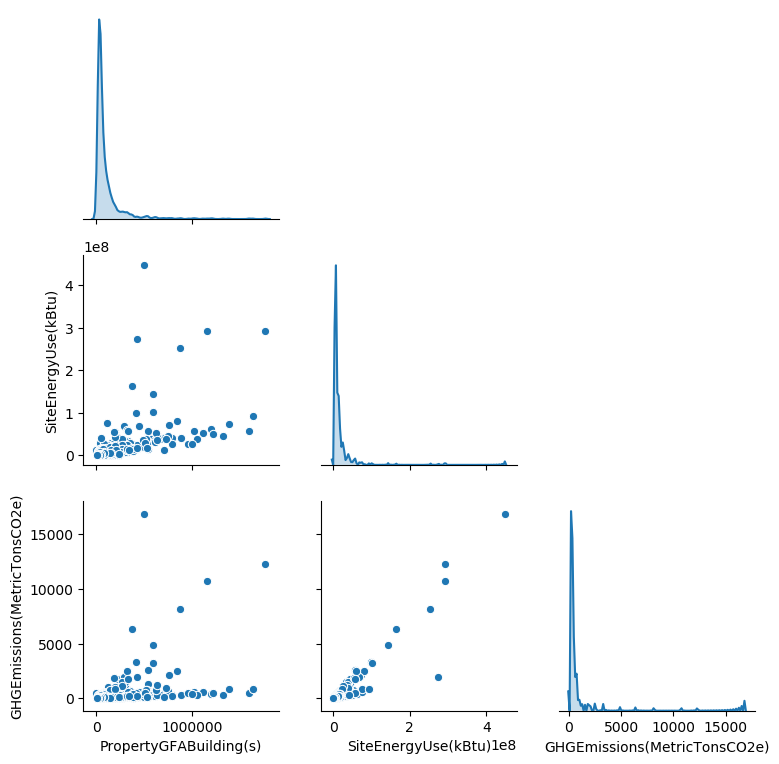

In [50]:
fig = sns.pairplot(buildings[['PropertyGFABuilding(s)', 'SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)']], corner=True, diag_kind='kde')
fig.savefig('img_energy_pairplot.png', dpi=250, quality=95, transparent=True)

La corrélation en la consommation d'énergie et les émissions de CO2 est confirmée. Pour une modélisation efficace, il faudra prévoir des transformations simples de ces variables (passage au log).

---
# 9. Export CSV

In [51]:
buildings.to_csv('src/buildings.csv', index=False)